### **Downloading the data**

**Download reference file from NCBI in FASTA format**

In [15]:
! efetch -db nuccore -id U00096.3 -format fasta > data/reference/EcoliK12MG1655.fa

**Download reference file from NCBI in GB format**

In [16]:
! efetch -db nuccore -id U00096.3 -format gb > data/reference/EcoliK12MG1655.gb

**Download sample FASTQ files from SRA via `sra-tools`**

In [19]:
! fastq-dump -v --split-3 --gzip SRR17909485 -O data

Preference setting is: Prefer SRA Normalized Format files with full base quality scores if available.
SRR17909485 is an SRA Normalized Format file with full base quality scores.
Read 1251776 spots for SRR17909485
Written 1251776 spots for SRR17909485


### **Check the reads quality**

In [20]:
! fastqc data/SRR17909485_*.fastq.gz -o data/fastqc_results

application/gzip
Started analysis of SRR17909485_1.fastq.gz
application/gzip
Approx 5% complete for SRR17909485_1.fastq.gz
Approx 10% complete for SRR17909485_1.fastq.gz
Approx 15% complete for SRR17909485_1.fastq.gz
Approx 20% complete for SRR17909485_1.fastq.gz
Approx 25% complete for SRR17909485_1.fastq.gz
Approx 30% complete for SRR17909485_1.fastq.gz
Approx 35% complete for SRR17909485_1.fastq.gz
Approx 40% complete for SRR17909485_1.fastq.gz
Approx 45% complete for SRR17909485_1.fastq.gz
Approx 50% complete for SRR17909485_1.fastq.gz
Approx 55% complete for SRR17909485_1.fastq.gz
Approx 60% complete for SRR17909485_1.fastq.gz
Approx 65% complete for SRR17909485_1.fastq.gz
Approx 70% complete for SRR17909485_1.fastq.gz
Approx 75% complete for SRR17909485_1.fastq.gz
Approx 80% complete for SRR17909485_1.fastq.gz
Approx 85% complete for SRR17909485_1.fastq.gz
Approx 90% complete for SRR17909485_1.fastq.gz
Approx 95% complete for SRR17909485_1.fastq.gz
Analysis complete for SRR179094

#### **Per base sequence quality**

|Forward read|Reverse read|
|-|-|
|![Per base sequence quality R1.png](<attachment:Per base sequence quality R1.png>)|![Per base sequence quality R2.png](<attachment:Per base sequence quality R2.png>)|
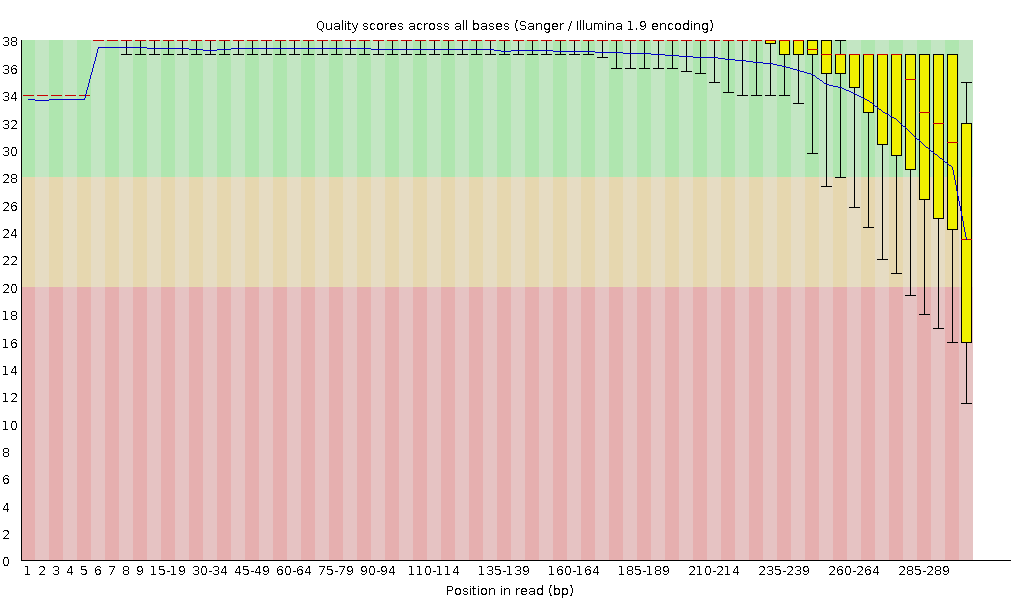
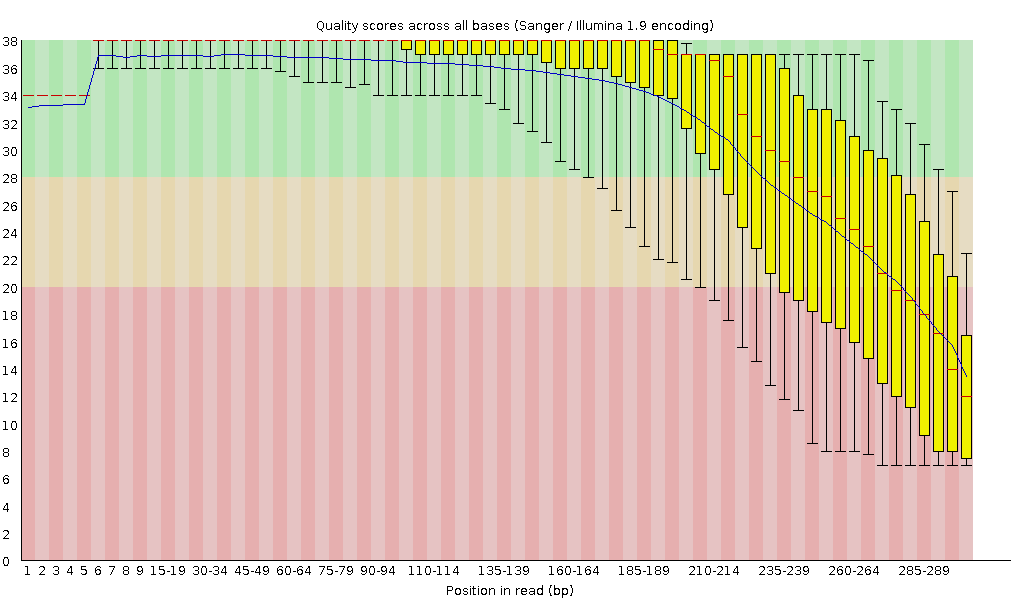

#### **Per sequence quality scores**

|Forward read|Reverse read|
|-|-|
|![Per sequence quality scores R1.png](<attachment:Per sequence quality scores R1.png>)|![Per sequence quality scores R2.png](<attachment:Per sequence quality scores R2.png>)|
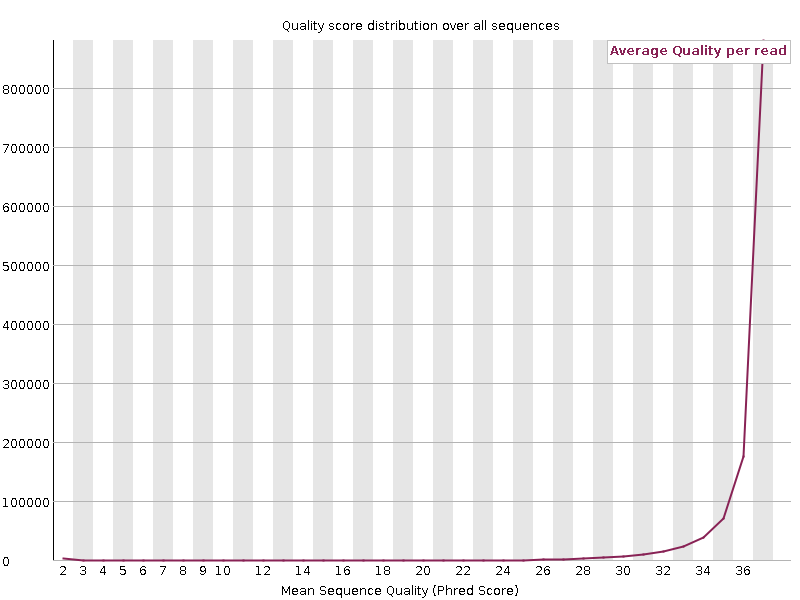
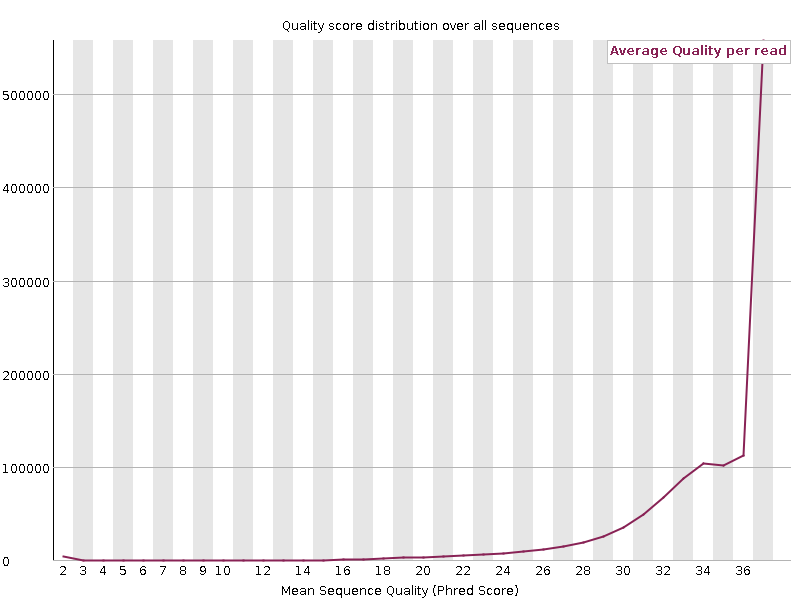

#### **Per base sequence content**

|Forward read|Reverse read|
|-|-|
|![Per base sequence content R1.png](<attachment:Per base sequence content R1.png>)|![Per base sequence content R2.png](<attachment:Per base sequence content R2.png>)|
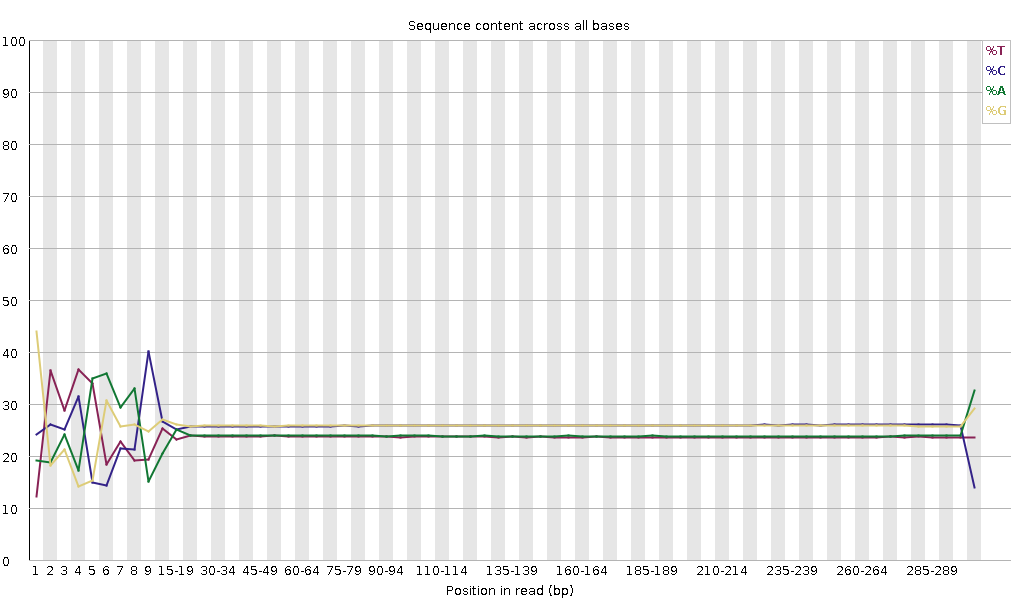
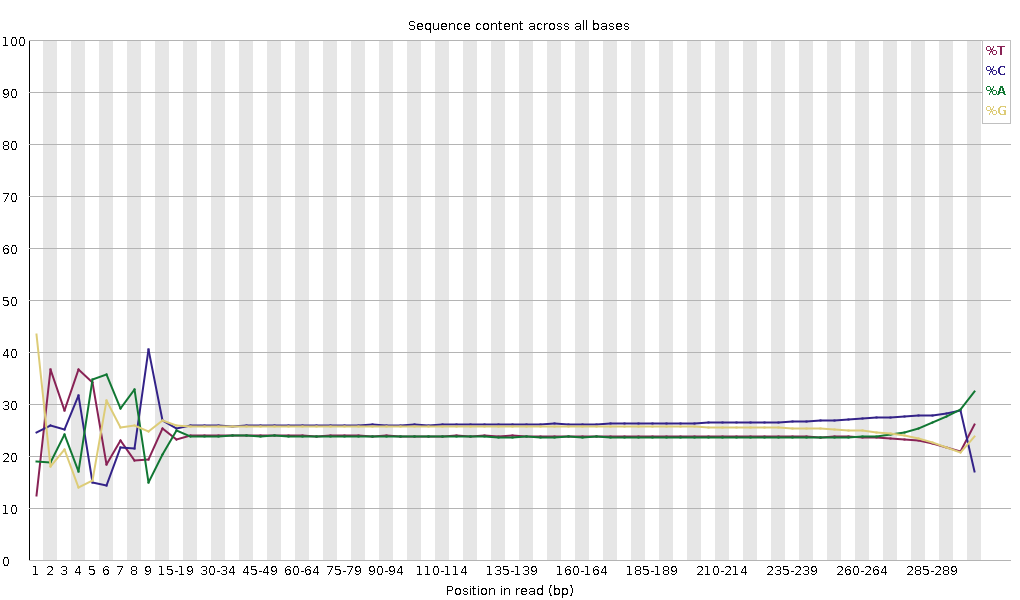

#### **Per sequence GC content**

|Forward read|Reverse read|
|-|-|
|![Per sequence GC content R1.png](<attachment:Per sequence GC content R1.png>)|![Per sequence GC content R2.png](<attachment:Per sequence GC content R2.png>)|
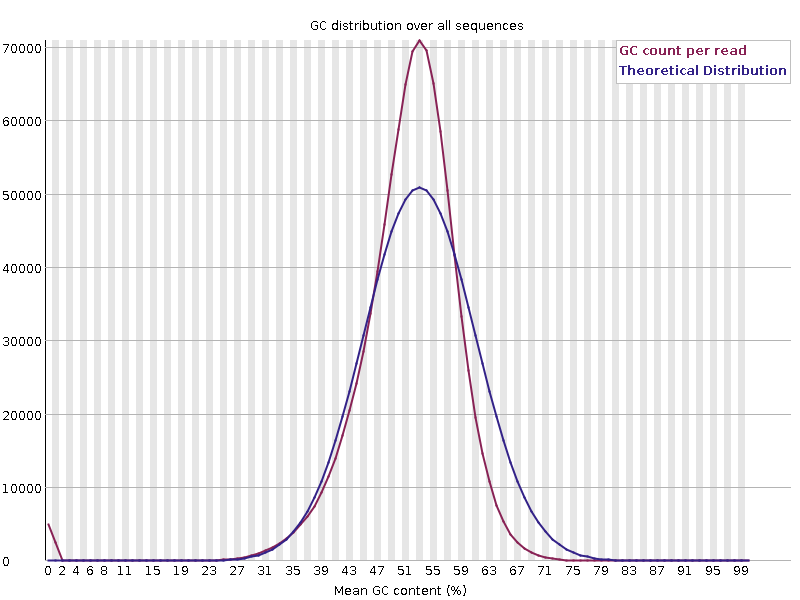
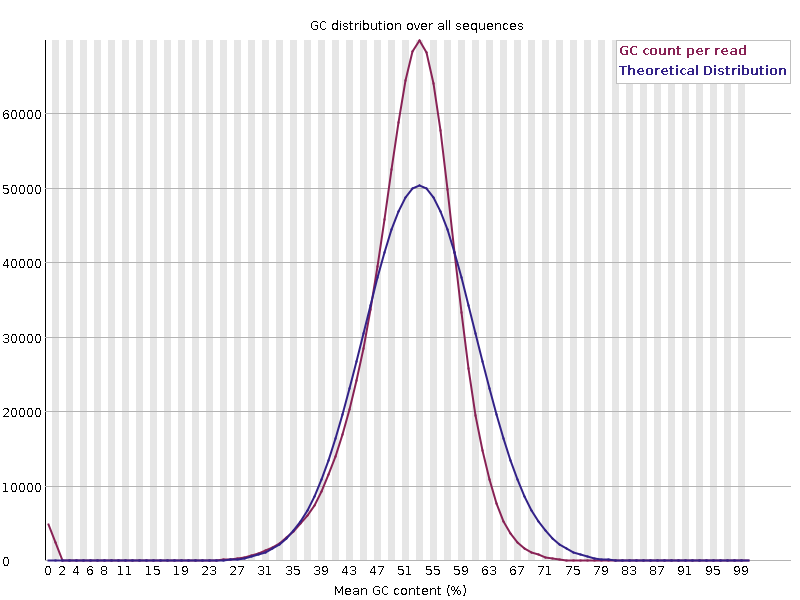

#### **Adapter Content**

|Forward read|Reverse read|
|-|-|
|![Adapter Content R1.png](<attachment:Adapter Content R1.png>)|![Adapter Content R2.png](<attachment:Adapter Content R2.png>)|
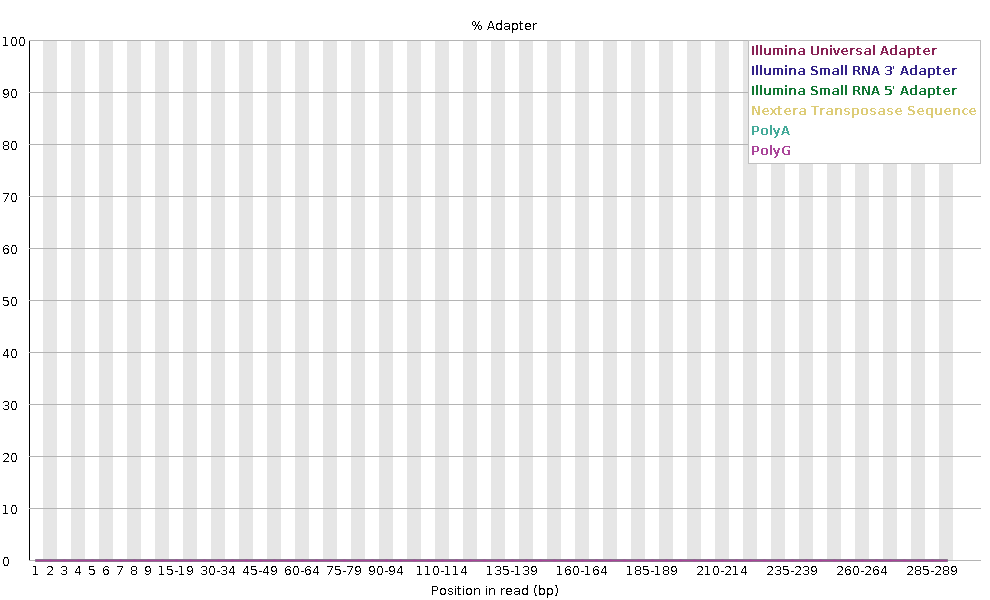
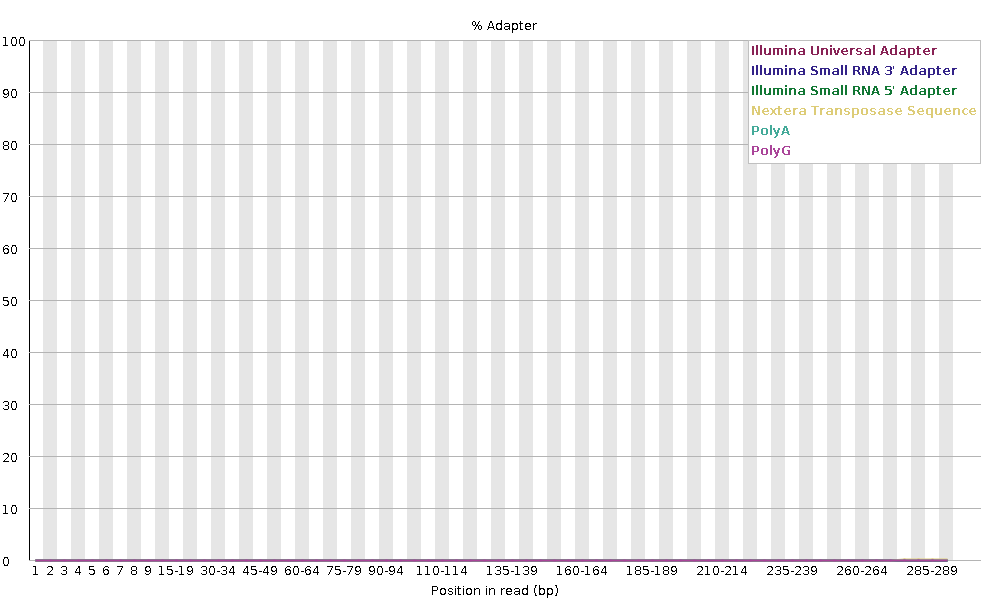

The main problem is `Per base sequence quality`. So we will solve it using `trimmomatic`.

### **Trim low-quality bases**

In [21]:
! trimmomatic PE -threads 2 data/SRR17909485_1.fastq.gz data/SRR17909485_2.fastq.gz \
    data/trimmed/SRR17909485_R1.trim.paired.fastq.gz data/trimmed/SRR17909485_R1.trim.unpaired.fastq.gz \
        data/trimmed/SRR17909485_R2.trim.paired.fastq.gz data/trimmed/SRR17909485_R2.trim.unpaired.fastq.gz \
            LEADING:22 TRAILING:22 SLIDINGWINDOW:6:22 MINLEN:32

TrimmomaticPE: Started with arguments:
 -threads 2 data/SRR17909485_1.fastq.gz data/SRR17909485_2.fastq.gz data/trimmed/SRR17909485_R1.trim.paired.fastq.gz data/trimmed/SRR17909485_R1.trim.unpaired.fastq.gz data/trimmed/SRR17909485_R2.trim.paired.fastq.gz data/trimmed/SRR17909485_R2.trim.unpaired.fastq.gz LEADING:22 TRAILING:22 SLIDINGWINDOW:6:22 MINLEN:32
Quality encoding detected as phred33
Input Read Pairs: 1251776 Both Surviving: 1205173 (96.28%) Forward Only Surviving: 34920 (2.79%) Reverse Only Surviving: 2954 (0.24%) Dropped: 8729 (0.70%)
TrimmomaticPE: Completed successfully


- `LEADING:22`: Removes low-quality bases from the start of the reads if they have a quality score lower than 22.
- `TRAILING:22`: Removes low-quality bases from the end of the reads if they have a quality score lower than 22.
- `SLIDINGWINDOW:6:22`: Performs a sliding window trimming. It scans the read with a 6-base wide window, cutting when the average quality per base drops below 22.
- `MINLEN:32`: Discards reads that are shorter than 32 bases after trimming.

Input Read Pairs: 1251776
- Both Surviving: 1205173 (96.28%)
- Forward Only Surviving: 34920 (2.79%)
- Reverse Only Surviving: 2954 (0.24%)
- Dropped: 8729 (0.70%)

### **Index reference**

In [22]:
! bwa index data/reference/EcoliK12MG1655.fa

[bwa_index] Pack FASTA... 0.08 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 1.42 seconds elapse.
[bwa_index] Update BWT... 0.03 sec
[bwa_index] Pack forward-only FASTA... 0.05 sec
[bwa_index] Construct SA from BWT and Occ... 0.68 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index data/reference/EcoliK12MG1655.fa
[main] Real time: 2.536 sec; CPU: 2.833 sec


### **Align to reference**

In [25]:
! bwa mem -t 2 -R '@RG\tID:1' \
    data/reference/EcoliK12MG1655.fa \
        data/trimmed/SRR17909485_R1.trim.paired.fastq.gz \
            data/trimmed/SRR17909485_R2.trim.paired.fastq.gz \
                | samtools view -b > data/bam/EcoliK12MG1655.SRR17909485.unsorted.bam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 111720 sequences (20000188 bp)...
[M::process] read 111754 sequences (20000158 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (4, 52775, 0, 2)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (105, 203, 329)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 777)
[M::mem_pestat] mean and std.dev: (231.84, 150.38)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1001)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 111720 reads in 7.749 CPU sec, 3.621 real sec
[M::process] read 112244 sequences (20000058 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 52869, 0, 3)
[M::mem_pestat] skip orientatio

### **Sort alignment**

In [26]:
! samtools sort --threads 2 data/bam/EcoliK12MG1655.SRR17909485.unsorted.bam > data/bam/EcoliK12MG1655.SRR17909485.sorted.bam

[bam_sort_core] merging from 0 files and 2 in-memory blocks...


### **Make bam index**

In [27]:
! samtools index data/bam/EcoliK12MG1655.SRR17909485.sorted.bam

### **Realign indels**

In [28]:
! abra2 --threads 2 --mad 100 --mbq 24 --ref data/reference/EcoliK12MG1655.fa --in data/bam/EcoliK12MG1655.SRR17909485.sorted.bam --out data/bam/EcoliK12MG1655.SRR17909485.final.bam

Picked up JAVA_TOOL_OPTIONS: -Xmx4G
INFO	Sun Mar 24 18:07:48 MSK 2024	Abra version: 2.24
INFO	Sun Mar 24 18:07:48 MSK 2024	Abra params: [/home/ilia/miniconda3/envs/ngs2/share/abra2-2.24-3/abra2.jar --threads 2 --mad 100 --mbq 24 --ref data/reference/EcoliK12MG1655.fa --in data/bam/EcoliK12MG1655.SRR17909485.sorted.bam --out data/bam/EcoliK12MG1655.SRR17909485.final.bam]
INFO	Sun Mar 24 18:07:48 MSK 2024	ABRA version: 2.24
INFO	Sun Mar 24 18:07:48 MSK 2024	input0: data/bam/EcoliK12MG1655.SRR17909485.sorted.bam
INFO	Sun Mar 24 18:07:48 MSK 2024	output0: data/bam/EcoliK12MG1655.SRR17909485.final.bam
INFO	Sun Mar 24 18:07:48 MSK 2024	regions: null
INFO	Sun Mar 24 18:07:48 MSK 2024	reference: data/reference/EcoliK12MG1655.fa
INFO	Sun Mar 24 18:07:48 MSK 2024	num threads: 2
INFO	Sun Mar 24 18:07:48 MSK 2024	minEdgeFrequency: 0
minNodeFrequncy: 1
minContigLength: -1
minBaseQuality: 24
minReadCandidateFraction: 0.01
maxAverageRegionDepth: 100
minEdgeRatio: 0.01

INFO	Sun Mar 24 18:07:48 MSK 20

### **Index final bam**

In [29]:
! samtools index data/bam/EcoliK12MG1655.SRR17909485.final.bam

### **Call variants**

In [2]:
! bcftools mpileup -Ou --max-depth 5000 -f data/reference/EcoliK12MG1655.fa data/bam/EcoliK12MG1655.SRR17909485.final.bam \
    | bcftools call -mv --ploidy 1 -Ov -o data/vcf/EcoliK12MG1655.SRR17909485.called.bcftools.vcf

[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 5000


`Mpileup` is actually a slightly different representation of alignment. `Mpileup` takes very simple things, it takes the number of reads aligned to each point and for each position in the reference genome it counts statistics - how many letters match the reference, how many mismatch, how many insertions, deletions.

Unfortunately `bcftools` is not multithreaded. If we do re-alignment with `abra2`, `bcftools` will work a bit faster.

`bcftools --ploidy 1` - we tell the program that we have a haploid genome.

`vcf` = variant call format.
This is actually a list of variations in a clear text format: chromosome, position, which letter was replaced by which letter, the quality of how much `bcftools` considers it important, some set of certain statistics (frequency of letter occurrence, etc.).

In [3]:
! tail data/vcf/EcoliK12MG1655.SRR17909485.called.bcftools.vcf

U00096.3	3110421	.	C	A	225.417	.	DP=41;VDB=0.454064;SGB=-0.692914;MQSBZ=1.45774;MQ0F=0;AC=1;AN=1;DP4=0,0,8,17;MQ=59	GT:PL	1:255,0
U00096.3	3560455	.	C	CG	225.417	.	INDEL;IDV=82;IMF=1;DP=82;VDB=0.0327919;SGB=-0.693147;MQSBZ=0;BQBZ=0.885506;MQ0F=0;AC=1;AN=1;DP4=0,0,37,45;MQ=60	GT:PL	1:255,0
U00096.3	4093770	.	C	T	225.417	.	DP=141;VDB=0.961761;SGB=-0.693147;MQSBZ=0;MQ0F=0;AC=1;AN=1;DP4=0,0,39,52;MQ=60	GT:PL	1:255,0
U00096.3	4161248	.	G	T	225.417	.	DP=117;VDB=0.400301;SGB=-0.693147;MQSBZ=0;MQ0F=0;AC=1;AN=1;DP4=0,0,36,33;MQ=60	GT:PL	1:255,0
U00096.3	4164123	.	C	G	225.417	.	DP=130;VDB=0.322528;SGB=-0.693147;MQSBZ=0;MQ0F=0;AC=1;AN=1;DP4=0,0,32,44;MQ=60	GT:PL	1:255,0
U00096.3	4296380	.	AC	ACGC	228.422	.	INDEL;IDV=98;IMF=0.989899;DP=99;VDB=8.47905e-05;SGB=-0.693147;RPBZ=-1.71529;MQBZ=1.83497;MQSBZ=-2.15139;BQBZ=-1.59515;SCBZ=-9.8995;MQ0F=0;AC=1;AN=1;DP4=0,1,47,51;MQ=54	GT:PL	1:255,0
U00096.3	4474834	.	A	G	225.417	.	DP=81;VDB=0.345282;SGB=-0.693147;MQSBZ=0;MQ0F=0;AC=1;AN=1;DP4=0,0,21,26;MQ=60	GT

### **Make snpEff database**

У `snpEff` есть база данных из уже хорошо просеквенированных, проаннотированных геномов многих известных организмов. `snpEff` загружает аннотации и во время аннотации `vcf` файла, он проверяет в какой ген в какое положение падает каждая конкретная вариация.<br>
По _E. coli_ у snpEff более 3500 баз данных, что многовато.<br>
Самый лучший способ справиться с этим - сделать свою собственную базу данных.

In [4]:
! mkdir -p data/EcoliK12MG1655

In [5]:
! cp data/reference/EcoliK12MG1655.gb data/EcoliK12MG1655/genes.gbk

In [9]:
! echo "EcoliK12MG1655.genome : EcoliK12MG1655\nEcoliK12MG1655.chromosomes : EcoliK12MG1655.gb\nEcoliK12MG1655.codonTable : Standard" \
    > snpEff.config

In [6]:
! snpEff build -c snpEff.config -genbank EcoliK12MG1655

00:00:00 Codon table 'Standard' for genome 'EcoliK12MG1655'
	Protein check:	EcoliK12MG1655	OK: 4298	Not found: 17	Errors: 0	Error percentage: 0.0%


### **Annotate variants**

In [7]:
! snpEff ann -v EcoliK12MG1655  data/vcf/EcoliK12MG1655.SRR17909485.called.bcftools.vcf > data/vcf/EcoliK12MG1655.SRR17909485.annotated.vcf

00:00:00 SnpEff version SnpEff 5.2 (build 2023-09-29 06:17), by Pablo Cingolani
00:00:00 Command: 'ann'
00:00:00 Reading configuration file 'snpEff.config'. Genome: 'EcoliK12MG1655'
00:00:00 Reading config file: /Users/ilyapopov/Desktop/2 - Genomic Variation Analysis/snpEff.config
00:00:00 Codon table 'Standard' for genome 'EcoliK12MG1655'
00:00:00 done
00:00:00 Reading database for genome version 'EcoliK12MG1655' from file '/Users/ilyapopov/Desktop/2 - Genomic Variation Analysis/./data/EcoliK12MG1655/snpEffectPredictor.bin' (this might take a while)
00:00:00 done
00:00:00 Loading Motifs and PWMs
00:00:00 Building interval forest
00:00:01 done.
00:00:01 Genome stats :
#-----------------------------------------------
# Genome name                : 'EcoliK12MG1655'
# Genome version             : 'EcoliK12MG1655'
# Genome ID                  : 'EcoliK12MG1655[0]'
# Has protein coding info    : true
# Has Tr. Support Level info : true
# Genes                      : 4639
# Protein coding ge

In [8]:
! mv snpEff_genes.txt EcoliK12MG1655.SRR17909485.snpEff_genes.txt

In [9]:
! mv snpEff_summary.html EcoliK12MG1655.SRR17909485.snpEff_summary.html

In [10]:
! tail data/vcf/EcoliK12MG1655.SRR17909485.annotated.vcf

U00096.3	3110421	.	C	A	225.417	.	DP=41;VDB=0.454064;SGB=-0.692914;MQSBZ=1.45774;MQ0F=0;AC=1;AN=1;DP4=0,0,8,17;MQ=59;ANN=A|upstream_gene_variant|MODIFIER|speC|b2965|transcript|b2965|protein_coding||c.-1266G>T|||||1266|,A|upstream_gene_variant|MODIFIER|yqgH|b4785|transcript|b4785|protein_coding||c.-1021G>T|||||1021|,A|upstream_gene_variant|MODIFIER|yqhJ|b4786|transcript|b4786|protein_coding||c.-845C>A|||||845|WARNING_TRANSCRIPT_NO_START_CODON,A|downstream_gene_variant|MODIFIER|mltC|b2963|transcript|b2963|protein_coding||c.*4909C>A|||||4909|,A|downstream_gene_variant|MODIFIER|nupG|b2964|transcript|b2964|protein_coding||c.*3451C>A|||||3451|,A|downstream_gene_variant|MODIFIER|yqgA|b2966|transcript|b2966|protein_coding||c.*161C>A|||||161|WARNING_TRANSCRIPT_NO_START_CODON,A|downstream_gene_variant|MODIFIER|yghD|b2968|transcript|b2968|protein_coding||c.*169G>T|||||169|,A|downstream_gene_variant|MODIFIER|yghE|b2969|transcript|b2969|protein_coding||c.*707G>T|||||707|WARNING_TRANSCRIPT_NO_START_C

The `vcf` file became significantly larger because the `ANN` (annotation) line appeared after all the technical information<br>
Example:<br>

```
ANN=T|missense_variant|MODERATE|yjjI|b4380|transcript|b4380|protein_coding|1/1|c.397C>A|p.Leu133Ile.
```

- There's been a substitution of a letter for the `T`.
- This is a `missence variant` mutation.
- Its effect is `MODERATE`.
- `yjjI` - gene name
- `b4380` - number of the transcript in which the substitution occurred.
- `protein_coding` - this is the protein coding site
- `c.397C>A` - replacement in nucleotide sequence
- `p.Leu133Ile` - subsequent substitution in protein sequence (133 leucine is replaced by isoleucine)

### **Filter high-quality variants**

Let's filter out high and moderate effect mutations:
- nonsense
- missense
- frameshifts

In [11]:
! SnpSift filter "(ANN[*].IMPACT has 'HIGH') | (ANN[*].IMPACT has 'MODERATE')" data/vcf/EcoliK12MG1655.SRR17909485.annotated.vcf > data/vcf/EcoliK12MG1655.SRR17909485.higheffect.vcf

In [12]:
! tail data/vcf/EcoliK12MG1655.SRR17909485.higheffect.vcf

U00096.3	705013	.	T	C	225.417	.	DP=103;VDB=0.0387749;SGB=-0.693147;MQSBZ=0;MQ0F=0;AC=1;AN=1;DP4=0,0,30,36;MQ=60;ANN=C|missense_variant|MODERATE|nagE|b0679|transcript|b0679|protein_coding|1/1|c.1070T>C|p.Leu357Ser|1070/1947|1070/1947|357/648||,C|upstream_gene_variant|MODIFIER|umpH|b0675|transcript|b0675|protein_coding||c.-4687A>G|||||4687|,C|upstream_gene_variant|MODIFIER|nagC|b0676|transcript|b0676|protein_coding||c.-3419A>G|||||3419|,C|upstream_gene_variant|MODIFIER|nagA|b0677|transcript|b0677|protein_coding||c.-2262A>G|||||2262|,C|upstream_gene_variant|MODIFIER|nagB|b0678|transcript|b0678|protein_coding||c.-1402A>G|||||1402|,C|upstream_gene_variant|MODIFIER|glnS|b0680|transcript|b0680|protein_coding||c.-1080T>C|||||1080|,C|upstream_gene_variant|MODIFIER|chiP|b0681|transcript|b0681|protein_coding||c.-3321T>C|||||3321|,C|upstream_gene_variant|MODIFIER|chiQ|b0682|transcript|b0682|protein_coding||c.-4777T>C|||||4777|	GT:PL	1:255,0
U00096.3	1337394	.	A	G	225.417	.	DP=65;VDB=0.915279;SGB=-